# Brain Tumor Classification - Data Exploration and Preprocessing

This notebook explores and preprocesses brain tumor datasets for classification tasks.
We'll work with:
1. **4-class tumor dataset**: glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor
2. **Binary archive_2 dataset**: Binary classification patches

Using PyTorch framework with image augmentation via Albumentations.

## 1. Environment Setup and Package Verification

In [1]:
# Verify Python environment
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
Python executable: c:\Users\Ammad\Documents\Projects\Personal\Brain\brain_tumor_env\Scripts\python.exe


## 2. Import Required Libraries

In [3]:
# Core libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder

# Image processing
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

print("All libraries imported successfully!")

All libraries imported successfully!


## 3. Display Library Versions

In [4]:
# Display versions of key libraries
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Albumentations version: {A.__version__}")
print(f"Pillow version: {Image.__version__}")

# Check CUDA availability
print(f"\nCUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.7.1+cu118
Torchvision version: 0.22.1+cu118
NumPy version: 2.1.2
Pandas version: 2.3.2
Matplotlib version: 3.10.6
Albumentations version: 2.0.8
Pillow version: 11.0.0

CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA version: 11.8
Using device: cuda


## 4. Set Up Data Paths and Project Structure

In [5]:
# Define project root and data paths
project_root = Path.cwd().parent  # Assuming notebook is in notebooks/ folder
print(f"Project root: {project_root}")

# Data paths
tumor_data_path = project_root / 'tumor' / 'tumor'
archive_data_path = project_root / 'archive_2'

# Output directories
models_dir = project_root / 'models'
outputs_dir = project_root / 'outputs'
configs_dir = project_root / 'configs'
src_dir = project_root / 'src'

# Create directories if they don't exist
for directory in [models_dir, outputs_dir, configs_dir, src_dir]:
    directory.mkdir(exist_ok=True)
    print(f"✓ {directory.name}/ directory ready")

print(f"\nTumor dataset path: {tumor_data_path}")
print(f"Archive dataset path: {archive_data_path}")
print(f"Tumor dataset exists: {tumor_data_path.exists()}")
print(f"Archive dataset exists: {archive_data_path.exists()}")

Project root: c:\Users\Ammad\Documents\Projects\Personal\Brain
✓ models/ directory ready
✓ outputs/ directory ready
✓ configs/ directory ready
✓ src/ directory ready

Tumor dataset path: c:\Users\Ammad\Documents\Projects\Personal\Brain\tumor\tumor
Archive dataset path: c:\Users\Ammad\Documents\Projects\Personal\Brain\archive_2
Tumor dataset exists: True
Archive dataset exists: True


## 5. Explore 4-Class Tumor Dataset

In [6]:
# Explore tumor dataset structure
if tumor_data_path.exists():
    tumor_classes = [d.name for d in tumor_data_path.iterdir() if d.is_dir()]
    print(f"Tumor dataset classes: {tumor_classes}")
    
    # Count images in each class
    class_counts = {}
    total_images = 0
    
    for class_name in tumor_classes:
        class_path = tumor_data_path / class_name
        image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')) + list(class_path.glob('*.jpeg'))
        count = len(image_files)
        class_counts[class_name] = count
        total_images += count
        print(f"  {class_name}: {count} images")
    
    print(f"\nTotal images in tumor dataset: {total_images}")
    
    # Create a DataFrame for visualization
    tumor_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
    print("\nTumor Dataset Summary:")
    print(tumor_df)
else:
    print("Tumor dataset not found!")

Tumor dataset classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
  glioma_tumor: 926 images
  meningioma_tumor: 937 images
  no_tumor: 500 images
  pituitary_tumor: 901 images

Total images in tumor dataset: 3264

Tumor Dataset Summary:
              Class  Count
0      glioma_tumor    926
1  meningioma_tumor    937
2          no_tumor    500
3   pituitary_tumor    901


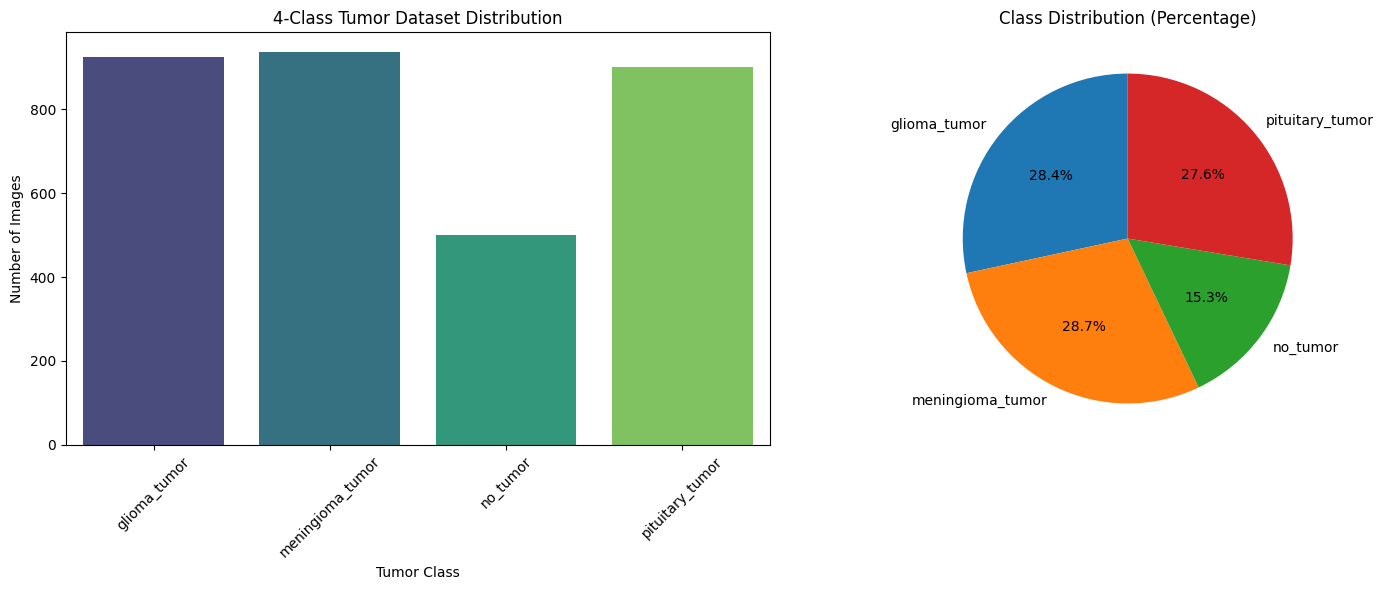


Dataset Balance Analysis:
Most represented class: 937 images
Least represented class: 500 images
Balance ratio (min/max): 0.534
✓ Dataset is reasonably balanced.


In [7]:
# Visualize class distribution for tumor dataset
if tumor_data_path.exists() and 'tumor_df' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    sns.barplot(data=tumor_df, x='Class', y='Count', ax=ax1, palette='viridis')
    ax1.set_title('4-Class Tumor Dataset Distribution')
    ax1.set_xlabel('Tumor Class')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart
    ax2.pie(tumor_df['Count'], labels=tumor_df['Class'], autopct='%1.1f%%', startangle=90)
    ax2.set_title('Class Distribution (Percentage)')
    
    plt.tight_layout()
    plt.show()
    
    # Show balance metrics
    max_count = tumor_df['Count'].max()
    min_count = tumor_df['Count'].min()
    balance_ratio = min_count / max_count
    print(f"\nDataset Balance Analysis:")
    print(f"Most represented class: {max_count} images")
    print(f"Least represented class: {min_count} images")
    print(f"Balance ratio (min/max): {balance_ratio:.3f}")
    if balance_ratio < 0.5:
        print("⚠️  Dataset is imbalanced. Consider using weighted loss or data augmentation.")
    else:
        print("✓ Dataset is reasonably balanced.")

## 6. Sample Images from Tumor Dataset

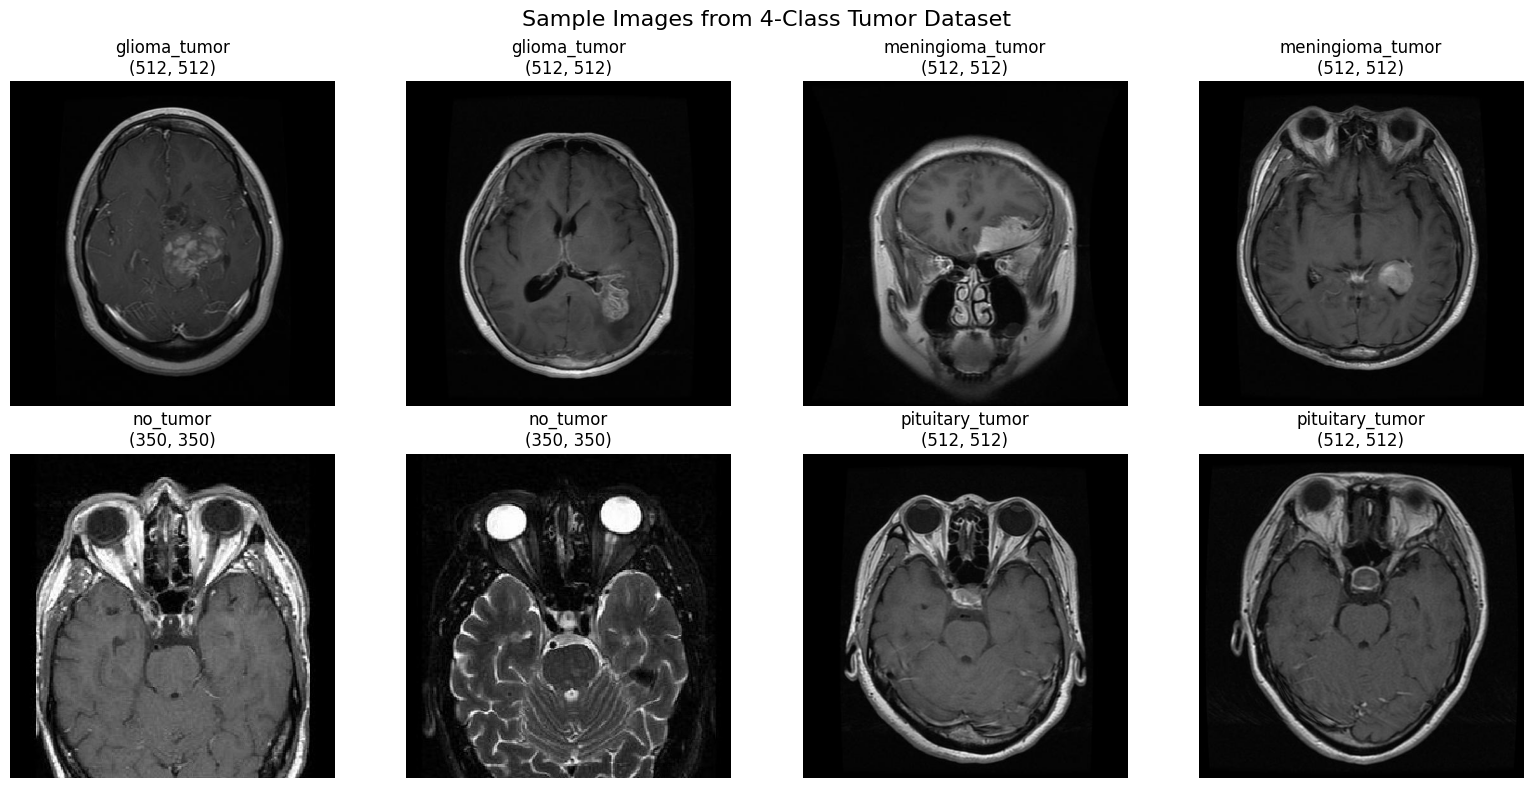

In [8]:
# Display sample images from each tumor class
if tumor_data_path.exists():
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    sample_idx = 0
    for class_name in tumor_classes:
        class_path = tumor_data_path / class_name
        image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png')) + list(class_path.glob('*.jpeg'))
        
        if image_files:
            # Show first two images from each class
            for i in range(min(2, len(image_files))):
                if sample_idx < 8:
                    img_path = image_files[i]
                    img = Image.open(img_path)
                    axes[sample_idx].imshow(img)
                    axes[sample_idx].set_title(f'{class_name}\n{img.size}')
                    axes[sample_idx].axis('off')
                    sample_idx += 1
    
    # Hide unused subplots
    for i in range(sample_idx, 8):
        axes[i].axis('off')
    
    plt.suptitle('Sample Images from 4-Class Tumor Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

## 7. Explore Archive_2 Binary Dataset

In [9]:
# Explore archive_2 dataset structure
if archive_data_path.exists():
    # Get list of subdirectories (patient folders)
    patient_folders = [d.name for d in archive_data_path.iterdir() if d.is_dir()]
    print(f"Number of patient folders in archive_2: {len(patient_folders)}")
    print(f"Sample patient folders: {patient_folders[:10]}")
    
    # Analyze a few patient folders to understand structure
    binary_class_counts = {'0': 0, '1': 0}
    patient_sample_analysis = []
    
    # Sample first 50 patient folders for analysis
    sample_patients = patient_folders[:50]
    
    for patient_id in tqdm(sample_patients, desc="Analyzing patient folders"):
        patient_path = archive_data_path / patient_id
        class_folders = [d.name for d in patient_path.iterdir() if d.is_dir()]
        
        patient_info = {'patient_id': patient_id, 'classes': class_folders}
        
        for class_name in class_folders:
            if class_name in ['0', '1']:
                class_path = patient_path / class_name
                image_count = len(list(class_path.glob('*.png')) + list(class_path.glob('*.jpg')))
                binary_class_counts[class_name] += image_count
                patient_info[f'class_{class_name}_count'] = image_count
        
        patient_sample_analysis.append(patient_info)
    
    print(f"\nBinary class distribution (from {len(sample_patients)} patients):")
    print(f"Class 0: {binary_class_counts['0']} images")
    print(f"Class 1: {binary_class_counts['1']} images")
    print(f"Total: {sum(binary_class_counts.values())} images")
    
    # Create DataFrame for analysis
    archive_sample_df = pd.DataFrame(patient_sample_analysis)
    print(f"\nSample patient folder analysis:")
    print(archive_sample_df.head())
    
else:
    print("Archive_2 dataset not found!")

Number of patient folders in archive_2: 280
Sample patient folders: ['10253', '10254', '10255', '10256', '10257', '10258', '10259', '10260', '10261', '10262']


Analyzing patient folders: 100%|██████████| 50/50 [00:01<00:00, 41.99it/s]


Binary class distribution (from 50 patients):
Class 0: 45734 images
Class 1: 16535 images
Total: 62269 images

Sample patient folder analysis:
  patient_id classes  class_0_count  class_1_count
0      10253  [0, 1]            479             70
1      10254  [0, 1]            772             76
2      10255  [0, 1]            181             91
3      10256  [0, 1]            351            117
4      10257  [0, 1]            427            208


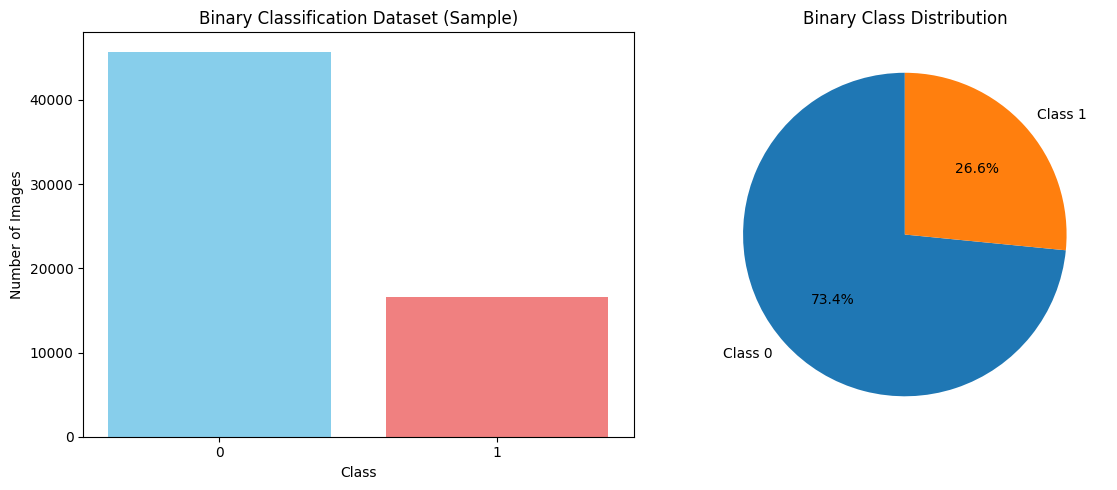


Binary Dataset Balance (from sample):
Class 0: 73.4%
Class 1: 26.6%
Balance ratio: 0.362


In [10]:
# Visualize binary dataset distribution
if archive_data_path.exists() and binary_class_counts['0'] > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot
    classes = list(binary_class_counts.keys())
    counts = list(binary_class_counts.values())
    
    ax1.bar(classes, counts, color=['skyblue', 'lightcoral'])
    ax1.set_title('Binary Classification Dataset (Sample)')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    
    # Pie chart
    ax2.pie(counts, labels=[f'Class {c}' for c in classes], autopct='%1.1f%%', startangle=90)
    ax2.set_title('Binary Class Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Balance analysis
    total = sum(counts)
    balance_ratio = min(counts) / max(counts) if max(counts) > 0 else 0
    print(f"\nBinary Dataset Balance (from sample):")
    print(f"Class 0: {counts[0]/total:.1%}")
    print(f"Class 1: {counts[1]/total:.1%}")
    print(f"Balance ratio: {balance_ratio:.3f}")

## 8. Sample Images from Archive_2 Dataset

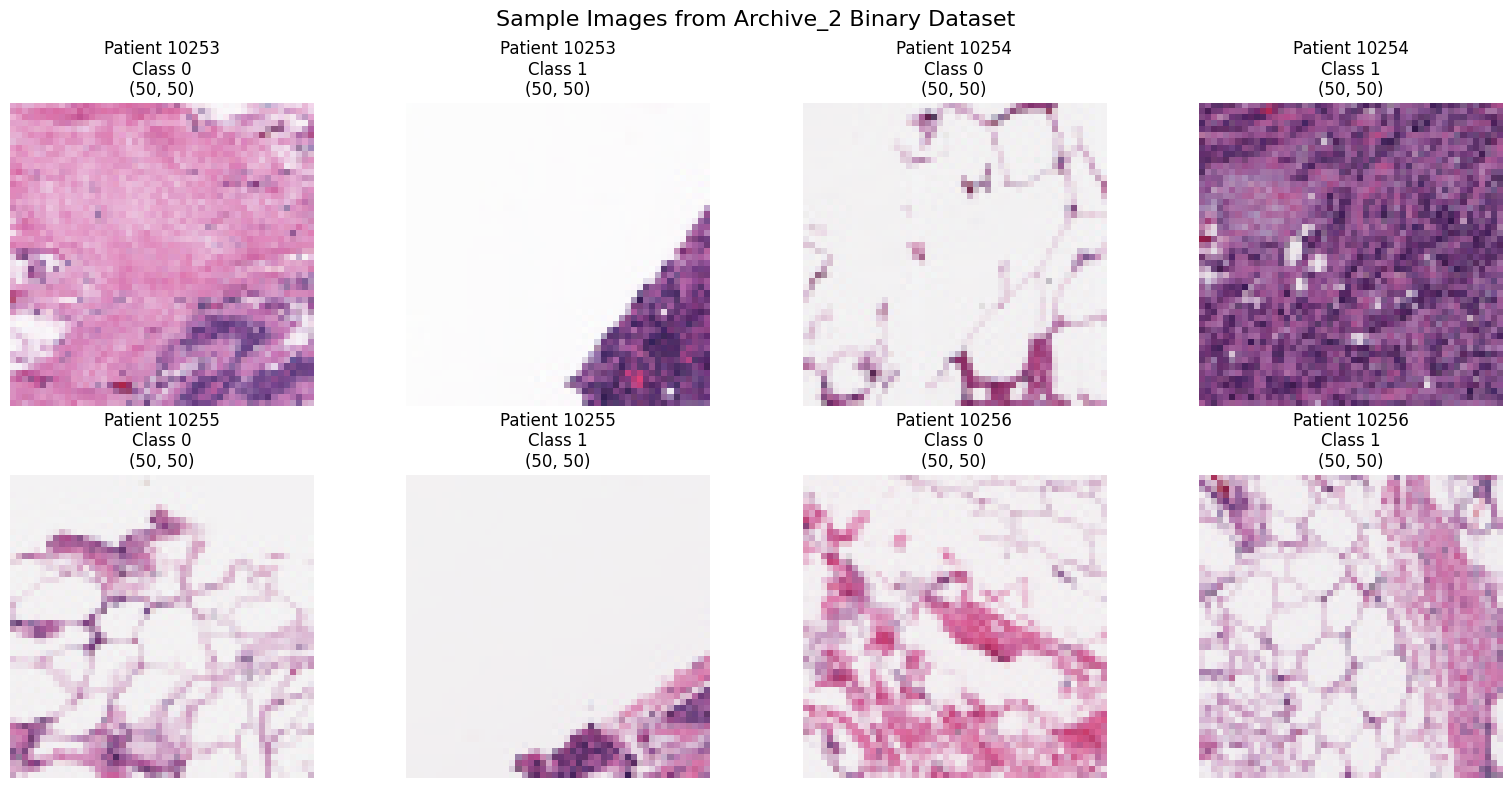

In [11]:
# Display sample images from archive_2 dataset
if archive_data_path.exists() and len(patient_folders) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    sample_idx = 0
    
    # Sample from first few patient folders
    for patient_id in patient_folders[:4]:
        patient_path = archive_data_path / patient_id
        
        for class_name in ['0', '1']:
            class_path = patient_path / class_name
            if class_path.exists():
                image_files = list(class_path.glob('*.png')) + list(class_path.glob('*.jpg'))
                
                if image_files and sample_idx < 8:
                    img_path = image_files[0]  # Take first image
                    try:
                        img = Image.open(img_path)
                        axes[sample_idx].imshow(img, cmap='gray' if img.mode == 'L' else None)
                        axes[sample_idx].set_title(f'Patient {patient_id}\nClass {class_name}\n{img.size}')
                        axes[sample_idx].axis('off')
                        sample_idx += 1
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    
    # Hide unused subplots
    for i in range(sample_idx, 8):
        axes[i].axis('off')
    
    plt.suptitle('Sample Images from Archive_2 Binary Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

## 9. Image Properties Analysis

In [12]:
# Analyze image properties for tumor dataset
def analyze_image_properties(dataset_path, dataset_name, max_samples=100):
    """Analyze image properties like size, format, mode"""
    print(f"\n=== {dataset_name} Image Properties Analysis ===")
    
    image_info = []
    sample_count = 0
    
    if dataset_name == "Tumor Dataset":
        # For tumor dataset
        for class_folder in dataset_path.iterdir():
            if class_folder.is_dir():
                image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.png')) + list(class_folder.glob('*.jpeg'))
                for img_path in image_files[:max_samples//4]:  # Sample from each class
                    try:
                        with Image.open(img_path) as img:
                            image_info.append({
                                'width': img.width,
                                'height': img.height,
                                'mode': img.mode,
                                'format': img.format,
                                'class': class_folder.name
                            })
                            sample_count += 1
                    except Exception as e:
                        print(f"Error analyzing {img_path}: {e}")
    
    else:
        # For archive dataset
        patient_folders = list(dataset_path.iterdir())[:10]  # Sample 10 patients
        for patient_folder in patient_folders:
            if patient_folder.is_dir():
                for class_folder in patient_folder.iterdir():
                    if class_folder.is_dir() and class_folder.name in ['0', '1']:
                        image_files = list(class_folder.glob('*.png')) + list(class_folder.glob('*.jpg'))
                        for img_path in image_files[:5]:  # Sample 5 images per class per patient
                            try:
                                with Image.open(img_path) as img:
                                    image_info.append({
                                        'width': img.width,
                                        'height': img.height,
                                        'mode': img.mode,
                                        'format': img.format,
                                        'class': class_folder.name
                                    })
                                    sample_count += 1
                                    if sample_count >= max_samples:
                                        break
                            except Exception as e:
                                print(f"Error analyzing {img_path}: {e}")
                        if sample_count >= max_samples:
                            break
                if sample_count >= max_samples:
                    break
    
    if image_info:
        df = pd.DataFrame(image_info)
        print(f"Analyzed {len(df)} images")
        
        # Summary statistics
        print(f"\nImage dimensions:")
        print(f"Width - Min: {df['width'].min()}, Max: {df['width'].max()}, Mean: {df['width'].mean():.1f}")
        print(f"Height - Min: {df['height'].min()}, Max: {df['height'].max()}, Mean: {df['height'].mean():.1f}")
        
        print(f"\nImage modes: {df['mode'].value_counts().to_dict()}")
        print(f"Image formats: {df['format'].value_counts().to_dict()}")
        
        # Most common dimensions
        df['dimensions'] = df['width'].astype(str) + 'x' + df['height'].astype(str)
        print(f"\nMost common dimensions:")
        print(df['dimensions'].value_counts().head())
        
        return df
    else:
        print("No images found or analyzed")
        return None

# Analyze both datasets
if tumor_data_path.exists():
    tumor_analysis = analyze_image_properties(tumor_data_path, "Tumor Dataset")

if archive_data_path.exists():
    archive_analysis = analyze_image_properties(archive_data_path, "Archive_2 Dataset")


=== Tumor Dataset Image Properties Analysis ===
Analyzed 100 images

Image dimensions:
Width - Min: 203, Max: 852, Mean: 473.6
Height - Min: 218, Max: 630, Mean: 471.3

Image modes: {'RGB': 100}
Image formats: {'JPEG': 100}

Most common dimensions:
dimensions
512x512    75
350x350     8
236x236     4
630x630     2
225x225     1
Name: count, dtype: int64

=== Archive_2 Dataset Image Properties Analysis ===
Analyzed 100 images

Image dimensions:
Width - Min: 50, Max: 50, Mean: 50.0
Height - Min: 50, Max: 50, Mean: 50.0

Image modes: {'RGB': 100}
Image formats: {'PNG': 100}

Most common dimensions:
dimensions
50x50    100
Name: count, dtype: int64
